# Sentiment Analysis

Sentiment analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. The purpose of this notebook is to perform a sentiment analysis on [this dataset from Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) which contains 50,000 movie reviews.

## Import the modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.regularizers import l2
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')

# Currently, memory growth needs to be the same across GPUs
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)])


Check the data for any null values. This takes out errors that are related to nan values. A value of false means that there's no null value in the dataset.

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df.isnull().values.any()

False

## Data distribution
Check the distribution of data. Ideally, the distribution of data between classes should be equal. Having a balanced data eliminates the issue of the algorithm forming a bias against the less frequent class. This also allows the use of easily interpretable evaluation metrics like accuracy. The result below shows that the data is evenly split between negative and positive classes.

In [4]:
data_comp = df.groupby('sentiment').count()
data_comp

,review
sentiment,
negative,25000
positive,25000


Having an equal distribution shows that accuracy is enough as the evaluation metric.

#### Create a pie chart for the data distribution

In [5]:
def pie_chart(labels, sizes):
    explode = (0.01, 0.01)  # only "explode" the 2nd slice (i.e. 'Hogs')
    plt.style.use('seaborn-muted')
    fig1, ax1 = plt.subplots(dpi = 100, figsize = (4, 4))
    ax1.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Data Distribution')
    plt.show()

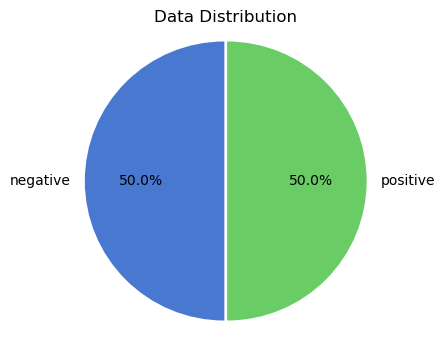

In [6]:
pie_chart(data_comp.index, data_comp['review'])

### Show review length

In [7]:
def review_length(list_of_data):
    fig, ax = plt.subplots(figsize = (6, 4), dpi = 100)

    box = plt.boxplot(list_of_data, vert = False, patch_artist = True, widths = 0.7, medianprops = {'color': 'black'}, whis = 1.5)
    plt.yticks(ticks = [1,2], labels = ['Negative', 'Positive'])
    plt.tick_params(axis = 'y', length = 0)
    plt.box(on = True)
    plt.style.use('seaborn-muted')
    plt.title('Review Lengths')
    plt.xlabel('Number of characters')

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    plt.show()

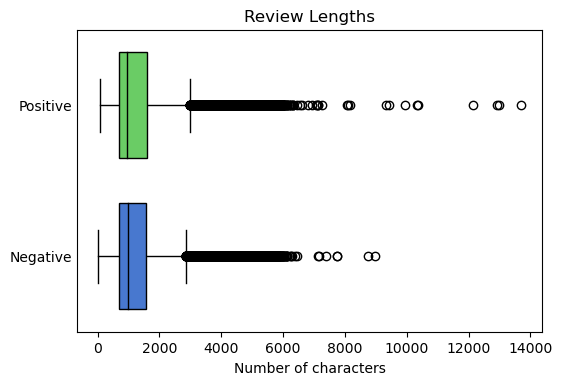

In [8]:
df['lengths'] = df['review'].apply(len)
data = [df['lengths'][df['sentiment'] == 'negative'], df['lengths'][df['sentiment'] == 'positive']]
review_length(data)

In [9]:
df.groupby('sentiment').describe()

lengths                                                        \
             count        mean          std   min    25%    50%      75%   
sentiment                                                                  
negative   25000.0  1294.06436   945.892669  32.0  706.0  973.0  1567.25   
positive   25000.0  1324.79768  1031.492627  65.0  691.0  968.0  1614.00   

                    
               max  
sentiment           
negative    8969.0  
positive   13704.0

There's no significant difference between the positive and negatives reviews though positive reviews have longer outliers.

## Data cleaning
This preprocesses the text so that the it can be easily understood by machine learning algorithms. The function 'cleaner' does the preprocessing of each input 'row'.

In [10]:
# Show original dataframe
df.head()

,review,sentiment,lengths
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [11]:
def cleaner(row):
    row = row.lower() # Set all the strings to lowercase
    row = re.sub(r'<.+?>', ' ', row) # Remove html tags
    row = re.sub(r'\W+', ' ', row) # Remove special characters
    row = re.sub(r'http\S+|www.\S+', ' ', row) # Remove links
    row = re.sub(r'[^a-zA-Z]', ' ', row) # Remove numbers
    row = re.sub(r'\b[\w]\b', '', row) # Remove single characters
    row = re.sub(r'\s+',' ', row) # Replace multiple spaces with single space 
    return row

In [12]:
# Perform the function 'cleaner' on each row of the dataframe
df2 = df.copy()
df2['review'] = df2['review'].apply(cleaner)
df2.head()

,review,sentiment,lengths
0,one of the other reviewers has mentioned that ...,positive,1761
1,wonderful little production the filming techn...,positive,998
2,thought this was wonderful way to spend time ...,positive,926
3,basically there family where little boy jake t...,negative,748
4,petter mattei love in the time of money is vis...,positive,1317


LabelEncoder transforms 'positive' and 'negative' results from the sentiment column to 1 and 0, respectively.

In [13]:
lb = LabelEncoder()
df2['sentiment'] = lb.fit_transform(df2['sentiment']).astype('int')
df2.head()

,review,sentiment,lengths
0,one of the other reviewers has mentioned that ...,1,1761
1,wonderful little production the filming techn...,1,998
2,thought this was wonderful way to spend time ...,1,926
3,basically there family where little boy jake t...,0,748
4,petter mattei love in the time of money is vis...,1,1317


Assign X as the input variable and Y as the output variable.

In [14]:
X = df2['review'] # This will serve as features
Y = df2['sentiment']

## Train and test data
Split the dataset into train and test subsets. The default values of the partition between the train and test sets are used below, which are 0.75 and 0.25, respectively. The 'random_state' is set to 0 for reproducible results.

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2)

## Vectorizer
The Term Frequency Inverse Document Frequency or TF-IDF is used as the vectorizer. The basic idea is that high weights are given to words that appear frequently in a document but appear few in the corpus. Low weights are given to words that appear frequently in the corpus, this gives stop words less meaning. TF-IDF is more suitable for a large dataset like this one instead of the Count Vectorizer, since the latter only counts the number of times a word appears in a document.

Set ngram_range is the range of sets of consecutive words. At the minimum, it captures single words, and at the maximum, it captures sets of 3 consecutive words.
Min_df is the minimum number of times a word needs to appear in a document before it can be included in the corpus.
Max_df is the maximum number of times a word needs to appear in a document before it can be included in the corpus.
Strip_accents removes character accents from strings.

In [16]:
cv = TfidfVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.2, stop_words = 'english', strip_accents = 'unicode')

# Fit the vectorizer to the training set. Transform converts the words into a sparse matrix. 
# Any words that is in the test set that did not appeared in the train set will be ignored. 
X_train_vector = cv.fit_transform(X_train)

## Baseline score
A dummy classifier is used to have a baseline score. The default strategy is used, which is stratified, for the dummy classifier since the distribution of the positive and negative reviews are equal. The dummy classifier serves as a sanity check for the classifier that will be used to train and test the data.

In [17]:
cls_d = DummyClassifier(strategy = 'stratified') # Instantiate the dummy classifier
cls_d.fit(X_train_vector, Y_train) # Train the model
pred = cls_d.predict(cv.transform(X_test)) # Predict the test test data

## Accuracy
Accuracy is the evaluation metric used due to the fact that the data is balanced and it is easier to interpret compared to other evaluation metrics like ROC-AUC, F1 score, etc.

In [18]:
acc_dum = accuracy_score(Y_test, pred)
print(f'Accuracy of Dummy Classifier is {(acc_dum * 100):.2f}%')

Accuracy of Dummy Classifier is 50.15%


## Classification
The 3 most common classification for sentiment analysis are going to be evaluated against each other. The evaluation metric is accuracy.

## Logistic Regression

#### Word cloud
A word cloud is a data visualization tool that is a collection of words displayed in different sizes. The word with the biggest font has the highest weight given by the classifier, while a word with a small font only has a small weight.

#### Create a class for the classifier

In [19]:
class Classifier:
    
    def __init__(self, cls):
        if cls == LogisticRegression:
            self.pclf = 'Logistic Regression'
        elif cls == MultinomialNB:
            self.pclf = 'Multinomial Naive Bayes'
        elif cls == LinearSVC:
            self.pclf = 'Linear Support Vector Classifier'
        else:
            self.pclf = 'NOTA'
        self.cls = cls
    
    def acc(self, x_train, y_train, x_test, y_test):
        self.clf = self.cls()
        self.clf.fit(x_train, y_train)
        acc = self.clf.score(cv.transform(x_test), y_test)
        return acc
        
    def wordc(self, cv):
        # Top 10 positive words
        pos = sorted(dict(zip(cv.get_feature_names(), self.clf.coef_[0])).items(), key = lambda x: x[1], reverse = True)
        print(f'Positive words for {self.pclf}')
        print(f'{pos[:10]}\n')
        
        # Top 10 negative words
        neg = sorted(dict(zip(cv.get_feature_names(), self.clf.coef_[0])).items(), key = lambda x: x[1], reverse = False)
        #return acc, pos, neg
        print(f'Negative words for {self.pclf}')
        print(f'{neg[:10]}\n')
        
        # Show the top 100 positive words using word cloud
        wc_pos = WordCloud(width = 2000, height = 2000, background_color = 'black', colormap = 'Pastel1').generate_from_frequencies(dict(pos[:100]))
        plt.figure(figsize = (10, 10))
        plt.title(f'Positive Words for {self.pclf}', fontsize = 20)
        plt.imshow(wc_pos)
        plt.axis(False)
        plt.show()

        # Show the top 100 negative words using word cloud
        wc_neg = WordCloud(width = 2000, height = 2000, background_color = 'black', colormap = 'Pastel1').generate_from_frequencies(dict(neg[:100]))
        plt.figure(figsize = (10, 10))
        plt.title(f'Negative Words for {self.pclf}', fontsize = 20)
        plt.imshow(wc_neg)
        plt.axis(False)
        plt.show()

In [16]:
lr = Classifier(LogisticRegression)
acc_lr = lr.acc(X_train_vector, Y_train, X_test, Y_test)
print(f'Accuracy is {(acc_lr * 100):.2f}%\n')
lr.wordc(cv)

Accuracy of Logistic Regression is 85.93%


## Multinomial Naive Bayes

In [17]:
mnb = Classifier(MultinomialNB)
acc_mnb = mnb.acc(X_train_vector, Y_train, X_test, Y_test)
print(f'Accuracy is {(acc_mnb * 100):.2f}%\n')
mnb.wordc(cv)

Accuracy of Multinomial Naive Bayes is 85.00%


Strange. Most of the negative sentiments are adjectives except for Aaron Spelling. Multinomial NB seems to associate movies produced by Aaron Spelling as negative. Either the movies produced by Aaron Spelling are bad or the classifier is wrong.

## Linear Support Vector Classifier

In [18]:
lsvc = Classifier(LinearSVC)
acc_lsvc = lsvc.acc(X_train_vector, Y_train, X_test, Y_test)
print(f'Accuracy is {(acc_lsvc * 100):.2f}%\n')
lsvc.wordc(cv)

Accuracy of Support Vector Classifier is 85.00%


## Bidirectional LSTM

#### Setting up some hyperparameters

In [ ]:
max_features = 5000 # Only consider the first 5000 words in the dataset
embed_size = 64 # Maximum number of categories that groups words into a meaning
max_length = 1000 # Only consider the first 1000 characters per sentence. 
# About 50% of the training data has a length of less than 1000 characters

In [ ]:
# Plot the histogram of the length of each row
plt.hist(X_train.apply(len).tolist(), bins = 'doane')

The distribution of the length of the movie reviews is right tailed. Most of the data is concentrated approximately less than 2000 characters but we will only use 1000 for the maximum length because anything larger than that crashes the notebook.

In [ ]:
np.percentile(X_train.apply(len), 55)

Approximately 55% of the length of the data is less than approximately 1000 characters.

### Tokenize the sentences

In [ ]:
# Instantiate the tokenizer
t = Tokenizer(num_words = max_features)

# Fits the training texts
t.fit_on_texts(list(X_train))

# Transforms the texts to integers
X_train_seq = t.texts_to_sequences(X_train)
X_test_seq = t.texts_to_sequences(X_test)

In [ ]:
# Shows the words included in the dataset. A lower index shows that the word appears frequently in the dataset
t.word_index

Obviously, stop words have low indices

### Pad the sentences to have uniform length

In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen = max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen = max_length, padding = 'post')

print(f'The shape of the training dataset is {X_train_pad.shape}')
print(f'The shape of the testing dataset is {X_test_pad.shape}')

## Create the model
The model is composed of two bidirectional LSTM hidden layers with 64 hidden units each. The model is terminated using a fully connected layer with a sigmoid activation. Word embeddings represents texts using vectors in a way where words with identical meaning are represented similarly. 

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embed_size, input_length = max_length))
model.add(Bidirectional(LSTM(units = 64, kernel_regularizer = l2(0.001), recurrent_regularizer = l2(0.001))))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

### Callbacks
The ModelCheckpoint callback is used in this model to save the best weights of the model. Early stopping stops the training of the model before the assigned epoch if the performance of the training set stops improving.

In [ ]:
cb = [EarlyStopping(patience = 4, monitor = 'val_loss', verbose = 1, restore_best_weights = True), 
      ModelCheckpoint('SentimentModel.h5', monitor = 'val_loss', save_best_only = True, verbose=1, save_weights_only=False, mode="min")]

### Fit the model

In [ ]:
model_history = model.fit(X_train_pad, Y_train, callbacks = cb, batch_size = 256, epochs = 20, verbose = 1, validation_data = (X_test_pad, Y_test))

### Test set evaluation

In [ ]:
acc_model = model.evaluate(X_test_pad, Y_test)
print(f'The model test accuracy is {(acc_model[1]*100):.2f}%')

#### Create a function for the metrics plot

In [ ]:
def plotter(history):
    
    # Plot the trained and testing loss
    met = [keys for keys in history.history.keys()][:2]
    for key in met:
        plt.figure(dpi = 100, figsize = (6,4))
        plt.plot(history.history[key], label = 'Train', marker = 'o', clip_on = False)
        plt.plot(history.history[f'val_{key}'], label = 'Test', linestyle = '-', marker = 'o', clip_on = False)
        plt.xlabel('Epoch')
        plt.ylabel(key.capitalize())
        plt.title(f'Model {key.capitalize()}')
        plt.xlim(0, len(history.history[key]) - 1)

        if key == 'loss':
            plt.legend(loc = 'upper right', frameon = False)
        else:
            plt.legend(loc = 'lower right', frameon = False)

            
        plt.gca().set_xticks(range(len(history.history[key])))
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.show()

In [ ]:
plotter(model_history)

## Plot the accuracy
#### Create a function for the accuracy comparison

In [ ]:
# Map the accuracy with the corresponding classifier
label = ['Dummy Classifier (Baseline)', 'Logistic Regression', 'Multinomial Naive Bayes', 'Linear Supper Vector Classifier', 'Bidirectional LSTM']
acc = [acc_dum, acc_lr, acc_mnb, acc_lsvc, acc_model[1]]
acc_dict = dict(zip(label, acc))

In [ ]:
def compare(di, metric):
    y = [i for i in range(len(di))]
        
    for idx, val in enumerate(metric):
        fig, ax = plt.subplots(dpi = 100, figsize = (6, 4))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks(y)
        ax.set_yticklabels(list(di.keys()))

        for i in range(len(di)):
            ax.text(list(di.values())[i] * 100, y[i], f'{(list(di.values())[i] * 100):.2f}%')
            plt.barh(y[i], list(di.values())[i] * 100, height = 0.5, align = 'center')

        plt.style.use('seaborn-muted')
        plt.tick_params(axis='both', length = 0)
        plt.suptitle(f'Test {val}', x = 0.51, y = 0.98)
        plt.xlabel(f'% {val}')

        if val == 'Loss':
            plt.title('(Lower is better)', fontsize=10)
        else:
            plt.title('(Higher is better)', fontsize=10)

        plt.show()   

In [ ]:
compare(acc_dict, metric =['Accuracy'])

## Summary
* Applied text preprocessing techniques to the dataset
* Demonstrated sentiment analysis using Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Classifier, and Bidirectional LSTM
* Linear SVC has the highest accuracy with 89.98%

## Recommendations
* Tweak the hyperparameters of the machine learning algorithms
* Use deep learning to classify the dataset

## Problems encountered
* Cant show test prediction of BiLSTM model due to lack of memory
* Cant do a validation split from the training data due to lack of memory
* Cant use a pretrained word embedding if a previous model is trained due to lack of memory